In [133]:
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [134]:
np.random.seed(0)

# Project Settings
## basic setting
asset price process follows BS model with $\mu=0.1, \sigma=0.25$
current spot price is 10 dollars
strike price is 10 dollars (option at the money)
transaction cost: 0.005 dollar per share, 0.005 dollar per option
only trade Integer number of shares and options
risk-free rate 5% per year

## Our position:
just sold 10_000 units of call at the money with 63 days to maturity (call this option g)
allow holding stock, bank account and another call option strike=10, maturity = 0.3 year (75.6 days) (call this option h)
Hedge frequency: 4 times per day

## Question 1
simulate 5000 paths, compare delta hedge and delta-gamma hedge pnl, how do they vary as $\mu$ varies ?

## Question 2
choose two sample path: one ends up in-the-money, one ends up out-of-money:
plot the hedging position of delta hedge and delta-gamma hedge, compare the two methods (transaction cost included)

## Question 3
suppose real-world P volatility is $\sigma \in ${20%,22%,...,30%} but you still sold the option and hedge using $\sigma=0.2$, compare again delta hedge and delta-gamma hedge


# Question 1

In [135]:
class BS_call():
    def __init__(self, S, T, K, sigma, r):
        self.S = S
        self.T = T
        self.K = K
        self.sigma = sigma
        self.r = r
        self.dp= (np.log(S/K) + (r+0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        self.dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
    
    def CallPrice(self):
        return self.S*stats.norm.cdf(self.dp) - self.K*np.exp(-self.r*self.T)*stats.norm.cdf(self.dm)
    
    
    def CallDelta(self):
        return stats.norm.cdf(self.dp)

    
    def CallGamma(self):
        return stats.norm.pdf(self.dp)/(self.S*sigma*np.sqrt(self.T))
    
    

In [136]:
class ATM_Call_Option_Dynamic_Hedging():
    def __init__(self,spot_price:float,mu:float,sigma:float,sigma_real:float,num_of_call_option_sold:int,Ntrials:int,option_maturity:float,hedging_frequency:float,type_of_hedge:str,hedging_option_maturity:Optional[float]=None,risk_free=0.05,stock_transaction_cost:float=0.005,option_transaction_cost:float=0.005,random_state:int=0):
        """
        
        :param spot_price: float, spot price of the underlying asset at t=0
        :param mu: BS model mu
        :param sigma: BS model sigma
        :param sigma_real: sigma under real-world P measure
        :param num_of_call_option_sold: int
        :param Ntrials: int
        :param option_maturity: float, maturity of the option we sold, fraction of year 
        :param hedging_frequency: how frequent we hedge, fraction of day
        :param type_of_hedge: ['delta','delta-gamma']
        :param hedging_option_maturity: optional, maturity of the option we use to hedge, fraction of year. only needed when type_of_hedge is 'delta-gamma'
        :param stock_transaction_cost: how much we pay for each stock transaction
        :param option_transaction_cost: how much we pay for each option transaction
        :param random_state: seed for np.random.seed
        """
        assert type_of_hedge in ['delta','delta-gamma']
        if type_of_hedge == 'delta':
            assert hedging_option_maturity is None
        else:
            assert hedging_option_maturity is not None
            self.hedging_option_maturity = hedging_option_maturity
            self.hedging_option_t = np.arange(0,hedging_option_maturity*252,hedging_frequency)
            self.hedging_option_time_to_maturity = self.hedging_option_t[::-1]
        
        np.random.seed(random_state)
        self.fraction_day_of_year = 1/252
        self.spot_price = spot_price
        self.strike_price = spot_price# ATM
        self.mu = mu
        self.sigma = sigma
        self.sigma_real = sigma_real
        self.num_of_call_option_sold = num_of_call_option_sold
        self.Ntrials = Ntrials
        self.type_of_hedge = type_of_hedge
        self.stock_transaction_cost = stock_transaction_cost
        self.option_transaction_cost = option_transaction_cost
        self.option_maturity = option_maturity
        self.hedging_frequency = hedging_frequency
        self.risk_free = risk_free
        
        self.sold_option_t = np.arange(0,option_maturity*252,hedging_frequency)
        self.sold_option_time_to_maturity = self.sold_option_t[::-1]
        
        self._GBM_stock_path_ = self.GBM_stock_path()
        self._Call_option_BS_price_, self._Call_option_BS_delta_, self._Call_option_BS_gamma_ = self.call_option_BS()
        if type_of_hedge == 'delta':
            self._delta_hedge_position_alpha_,self._delta_hedge_position_B_ = self.delta_hedge_position()
        else:
            self._delta_gamma_hedge_position_ = self.delta_gamma_hedge_position()
            pass
    def GBM_stock_path(self):
        res=np.empty((self.Ntrials,len(self.sold_option_t)))
        res[:,0]=self.spot_price
        for i in range(1,len(self.sold_option_t)):
            res[:,i]=res[:,i-1]*np.exp((self.mu-self.sigma_real**2/2)*(self.hedging_frequency*self.fraction_day_of_year)+self.sigma_real*np.sqrt(self.fraction_day_of_year*self.hedging_frequency)*np.random.randn(self.Ntrials))
        return res
    def call_option_BS(self):
        res=np.empty((self.Ntrials,len(self.sold_option_t)))
        res_delta=np.empty((self.Ntrials,len(self.sold_option_t)))
        res_gamma=np.empty((self.Ntrials,len(self.sold_option_t)))
        for i in range(len(self.sold_option_t)):
            BS=BS_call(self._GBM_stock_path_[:,i],self.sold_option_time_to_maturity[i]*self.fraction_day_of_year,self.spot_price,self.sigma_real,self.risk_free)
            res[:,i]=BS.CallPrice()
            res_delta[:,i]=BS.CallDelta()
            res_gamma[:,i]=BS.CallGamma()
        return res,res_delta,res_gamma
    def delta_hedge_position(self):
        """
        :return: alpha: short position in stock, 
        B: long position in bank account to make our portfolio self-financing (Ntrials,length_days*4) 
        """
        alpha = (-self._Call_option_BS_delta_*self.num_of_call_option_sold).astype(int)
        B = np.empty((self.Ntrials,len(self.sold_option_t)))
        B[:,0]=self._Call_option_BS_price_[:,0]*self.num_of_call_option_sold-alpha[:,0]*self._GBM_stock_path_[:,0]-self.stock_transaction_cost*np.abs(alpha[:,0]*self._GBM_stock_path_[:,0])
        for i in range(1,len(self.sold_option_t)-1):
            B[:,i]=B[:,i-1]*np.exp(self.risk_free*self.fraction_day_of_year*self.hedging_frequency)
            B[:,i]=B[:,i]-alpha[:,i]*self._GBM_stock_path_[:,i]-self.stock_transaction_cost*np.abs(alpha[:,i]*self._GBM_stock_path_[:,i])
        # the last quarter day
        B[:,-1]=B[:,-2]*np.exp(self.risk_free*self.fraction_day_of_year*self.hedging_frequency)
        B[:,-1]=B[:,-1]+alpha[:,-2]*self._GBM_stock_path_[:,-1]-self.stock_transaction_cost*np.abs(alpha[:,-2]*self._GBM_stock_path_[:,-1])-np.maximum(self._GBM_stock_path_[:,-1]-self.strike_price,0)*self.num_of_call_option_sold
        return alpha,B

    def delta_gamma_hedge_position(self):
        pass

In [137]:
base_scenario=ATM_Call_Option_Dynamic_Hedging(10,0.1,0.25,0.25,10_000,5000,63/252,1/4,'delta')

C:\Users\kevin\AppData\Local\Temp\ipykernel_11712\3738507336.py:8: RuntimeWarning: divide by zero encountered in divide
  self.dp= (np.log(S/K) + (r+0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
C:\Users\kevin\AppData\Local\Temp\ipykernel_11712\3738507336.py:9: RuntimeWarning: divide by zero encountered in divide
  self.dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
C:\Users\kevin\AppData\Local\Temp\ipykernel_11712\3738507336.py:20: RuntimeWarning: invalid value encountered in divide
  return stats.norm.pdf(self.dp)/(self.S*sigma*np.sqrt(self.T))


In [138]:
base_scenario.hedging_frequency

0.25

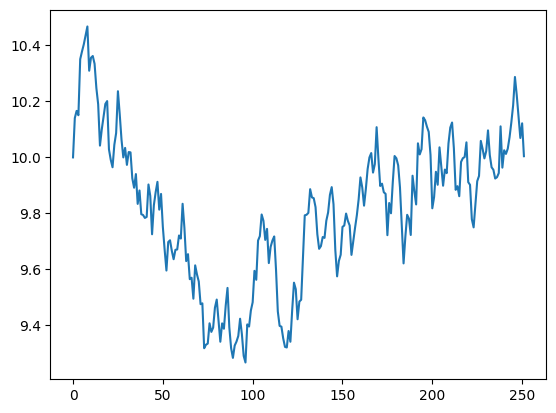

In [139]:
plt.plot(base_scenario._GBM_stock_path_[0,:])

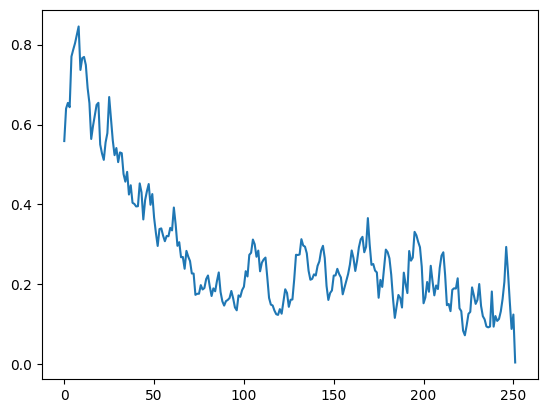

In [140]:
plt.plot(base_scenario._Call_option_BS_price_[0,:])

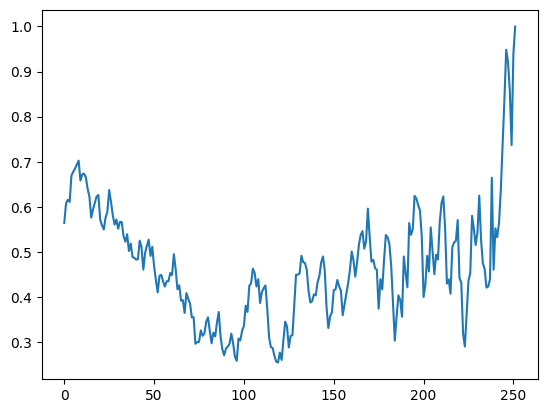

In [141]:
plt.plot(base_scenario._Call_option_BS_delta_[0,:])

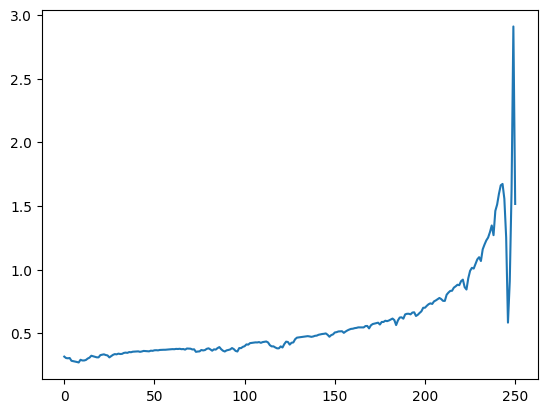

In [142]:
plt.plot(base_scenario._Call_option_BS_gamma_[0,:])

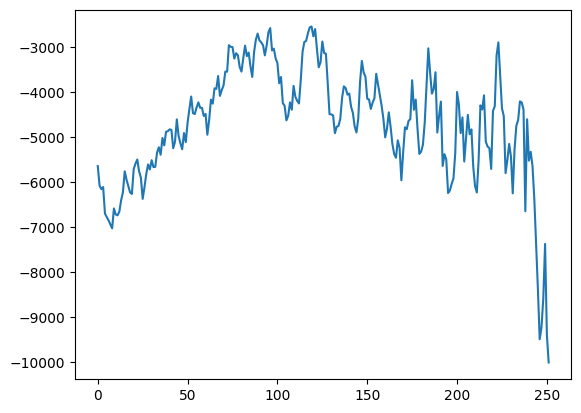

In [143]:
plt.plot(base_scenario._delta_hedge_position_alpha_[0,:])

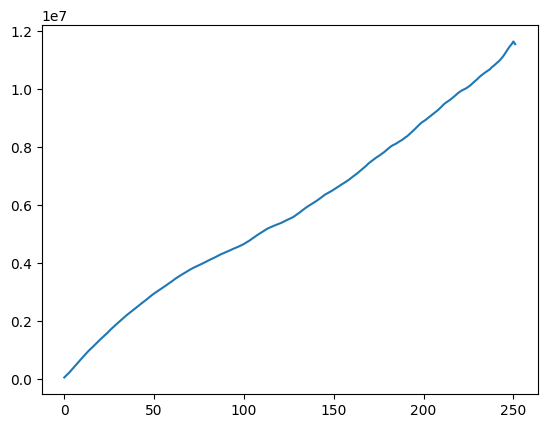

In [144]:
plt.plot(base_scenario._delta_hedge_position_B_[0,:])